# **Fraud Detection**

Fraud detection refers to the process of identifying and preventing fraudulent activities within various systems, such as financial transactions, online platforms, insurance claims, and more. It involves the use of various techniques, including data analysis, machine learning algorithms, pattern recognition, and anomaly detection, to identify suspicious behavior or transactions that deviate from normal patterns. The goal is to detect and prevent fraudulent activities before they cause financial loss or harm to individuals or organizations.

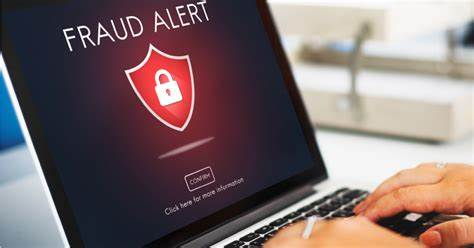


# Retrieve data from Kaggle with Kaggle API
source: https://www.kaggle.com/datasets/dermisfit/fraud-transactions-dataset

In [ ]:
from google.colab import files

# Upload the kaggle.json file
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xeooxes","key":"137fc4475cf3bd851733377b0abdfff3"}'}

# API kaggle

In [ ]:
import os

# Make a directory for Kaggle config
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the kaggle directory
!mv kaggle.json ~/.kaggle/

# Set the permissions of the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Install Kaggle API client
!pip install kaggle

# Download the dataset
!kaggle datasets download -d dermisfit/fraud-transactions-dataset


Dataset URL: https://www.kaggle.com/datasets/dermisfit/fraud-transactions-dataset
License(s): CC0-1.0
 93% 187M/202M [00:01<00:00, 171MB/s]
100% 202M/202M [00:01<00:00, 143MB/s]


In [ ]:
# unzip zip
!unzip /content/fraud-transactions-dataset.zip

Archive:  /content/fraud-transactions-dataset.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


# Import Libary

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# EDA
 EDA is the process of analyzing and visualizing data sets to summarize their main characteristics, often employing statistical graphics and other data visualization techniques. It involves understanding the structure and content of the data, identifying patterns, detecting outliers, and formulating hypotheses that can be tested further. EDA is typically performed before modeling to gain insights into the data and inform subsequent analysis and modeling decisions.

In [ ]:
# Membaca data dari file CSV
df_train = pd.read_csv('/content/fraudTrain.csv')
df_test = pd.read_csv('/content/fraudTest.csv')

# Memisahkan data berdasarkan nilai kolom 'is_fraud'
df_fraud_train = df_train[df_train['is_fraud'] == 1]
df_not_fraud_train = df_train[df_train['is_fraud'] == 0]

# Menentukan jumlah baris di mana 'is_fraud' bernilai 1 pada data train
num_fraud_rows_train = len(df_fraud_train)

# Mengambil jumlah baris yang sama dari data di mana 'is_fraud' bernilai 0 pada data train
df_not_fraud_sample_train = df_not_fraud_train.sample(n=num_fraud_rows_train, random_state=42)

# Menggabungkan kedua subset data tersebut
df_balanced_train = pd.concat([df_fraud_train, df_not_fraud_sample_train])

# Mengacak kembali baris dalam DataFrame yang baru
df_balanced_train = df_balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Menampilkan jumlah baris dari setiap kategori
print(f"Total baris dalam data train yang seimbang: {len(df_balanced_train)}")
print(df_balanced_train['is_fraud'].value_counts())

# Memisahkan data berdasarkan nilai kolom 'is_fraud' pada data test
df_fraud_test = df_test[df_test['is_fraud'] == 1]
df_not_fraud_test = df_test[df_test['is_fraud'] == 0]

# Menentukan jumlah baris di mana 'is_fraud' bernilai 1 pada data test
num_fraud_rows_test = len(df_fraud_test)

# Mengambil jumlah baris yang sama dari data di mana 'is_fraud' bernilai 0 pada data test
df_not_fraud_sample_test = df_not_fraud_test.sample(n=num_fraud_rows_test, random_state=42)

# Menggabungkan kedua subset data tersebut
df_balanced_test = pd.concat([df_fraud_test, df_not_fraud_sample_test])

# Mengacak kembali baris dalam DataFrame yang baru
df_balanced_test = df_balanced_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Menampilkan jumlah baris dari setiap kategori
print(f"Total baris dalam data test yang seimbang: {len(df_balanced_test)}")
print(df_balanced_test['is_fraud'].value_counts())

Total baris dalam data train yang seimbang: 15012
is_fraud
1    7506
0    7506
Name: count, dtype: int64
Total baris dalam data test yang seimbang: 4290
is_fraud
0    2145
1    2145
Name: count, dtype: int64


In [ ]:
df_balanced_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15012 non-null  int64  
 1   trans_date_trans_time  15012 non-null  object 
 2   cc_num                 15012 non-null  int64  
 3   merchant               15012 non-null  object 
 4   category               15012 non-null  object 
 5   amt                    15012 non-null  float64
 6   first                  15012 non-null  object 
 7   last                   15012 non-null  object 
 8   gender                 15012 non-null  object 
 9   street                 15012 non-null  object 
 10  city                   15012 non-null  object 
 11  state                  15012 non-null  object 
 12  zip                    15012 non-null  int64  
 13  lat                    15012 non-null  float64
 14  long                   15012 non-null  float64
 15  ci

In [ ]:
df_balanced_train.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [ ]:
# Menyimpan kolom is_fraud
is_fraud_train = df_balanced_train['is_fraud']
is_fraud_test = df_balanced_test['is_fraud']

# Menentukan kolom-kolom yang akan di-drop
cols_drop = []
for col in df_balanced_train.columns:
    if col not in ['is_fraud'] and df_balanced_train[col].dtype != 'float64' and df_balanced_train[col].dtype != 'int64':
        cols_drop.append(col)

# Membuat DataFrame yang telah direduksi untuk data train
df_reduced_train = df_balanced_train.drop(columns=cols_drop)
# Membuat DataFrame yang telah direduksi untuk data test
df_reduced_test = df_balanced_test.drop(columns=cols_drop)

# Data preprocessing
Data preprocessing is a series of steps performed to clean, adjust, and prepare raw data for further analysis. These steps include removing invalid or irrelevant data, handling missing values, transforming data into suitable formats, and reducing the dimensionality or complexity of data if necessary. The goal of data preprocessing is to improve the quality of data and ensure that the data used for analysis or modeling is of the highest quality.

# Feature Engineeering
 Feature engineering is the process of selecting, transforming, and creating new features (variables) from the raw data to improve the performance of machine learning models. This involves identifying relevant features, handling missing or redundant data, encoding categorical variables, scaling numerical features, and creating new features through mathematical transformations, aggregations, or domain knowledge. Effective feature engineering can significantly enhance the predictive power and generalization of machine learning models by providing them with more informative and discriminative input features.

In [ ]:
# Standarisasi data
scaler = StandardScaler()
scaled_fitur_train = scaler.fit_transform(df_reduced_train.drop(columns=['is_fraud']))
scaled_fitur_test = scaler.transform(df_reduced_test.drop(columns=['is_fraud']))

# Nama asli kolom fitur
original_feature_names = df_reduced_train.drop(columns=['is_fraud']).columns.tolist()

# PCA
pca = PCA(n_components=5)
pca_feature_train = pca.fit_transform(scaled_fitur_train)
pca_feature_test = pca.transform(scaled_fitur_test)

# Menambahkan hasil PCA ke DataFrame dengan nama asli fitur
pca_df_train = pd.DataFrame(data=pca_feature_train, columns=[f'PCA_{original_feature_names[i]}' for i in range(5)])
pca_df_train['is_fraud'] = is_fraud_train.values

pca_df_test = pd.DataFrame(data=pca_feature_test, columns=[f'PCA_{original_feature_names[i]}' for i in range(5)])
pca_df_test['is_fraud'] = is_fraud_test.values



In [ ]:
pca_df_train

,PCA_Unnamed: 0,PCA_cc_num,PCA_amt,PCA_zip,PCA_lat,is_fraud
0,3.341308,0.125408,2.398439,0.127257,-0.264499,1
1,0.409193,-1.915869,-1.022196,1.118428,0.514158,1
2,0.219692,2.301958,1.088688,-0.449292,-0.572120,0
3,-0.266952,1.732328,0.563745,-0.516896,-0.581130,0
4,-1.264211,-1.732402,-3.167932,-0.826115,-0.618886,1
...,...,...,...,...,...,...
15007,-1.850217,0.278259,1.218817,-0.487115,-0.509807,1
15008,-1.207249,-1.652607,-3.305122,-0.397475,-0.633514,0
15009,-0.609945,0.076539,1.226065,0.163156,-0.143418,1
15010,0.024693,1.753451,-1.419389,0.080273,-0.215255,1


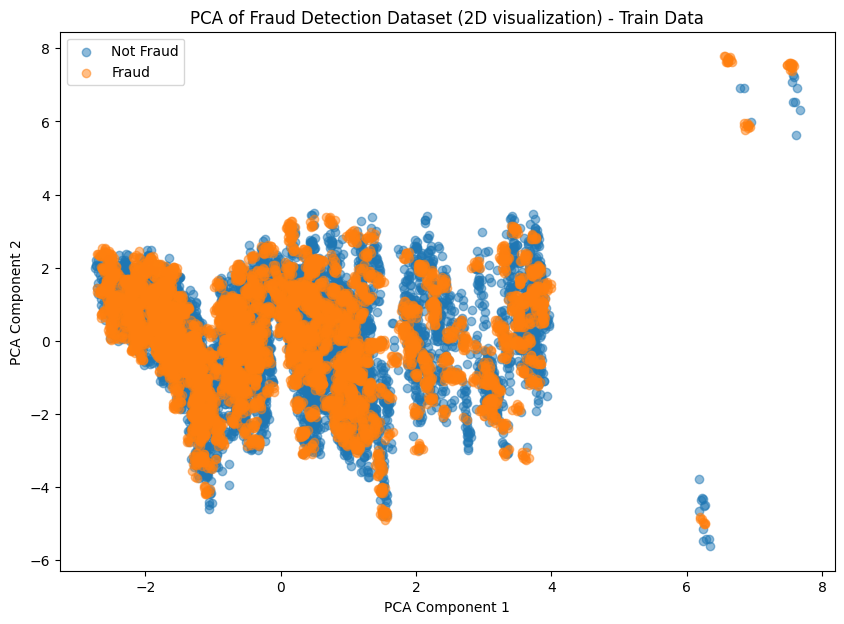

In [ ]:

# Visualisasi hasil PCA
plt.figure(figsize=(10, 7))
plt.scatter(pca_df_train[pca_df_train['is_fraud'] == 0]['PCA_Unnamed: 0'],
            pca_df_train[pca_df_train['is_fraud'] == 0]['PCA_cc_num'],
            label='Not Fraud', alpha=0.5)
plt.scatter(pca_df_train[pca_df_train['is_fraud'] == 1]['PCA_Unnamed: 0'],
            pca_df_train[pca_df_train['is_fraud'] == 1]['PCA_cc_num'],
            label='Fraud', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Fraud Detection Dataset (2D visualization) - Train Data')
plt.legend()

# Save the image
plt.savefig('pca_visualization_train.png')

plt.show()

In [ ]:
# Menampilkan proporsi variansi dari 5 komponen utama
explained_variance = pca.explained_variance_ratio_
print('Explained variance by each component:')
for i, variance in enumerate(explained_variance):
    print(f'Principal Component {i+1}: {variance:.2f}')

Explained variance by each component:
Principal Component 1: 0.29
Principal Component 2: 0.21
Principal Component 3: 0.20
Principal Component 4: 0.10
Principal Component 5: 0.10


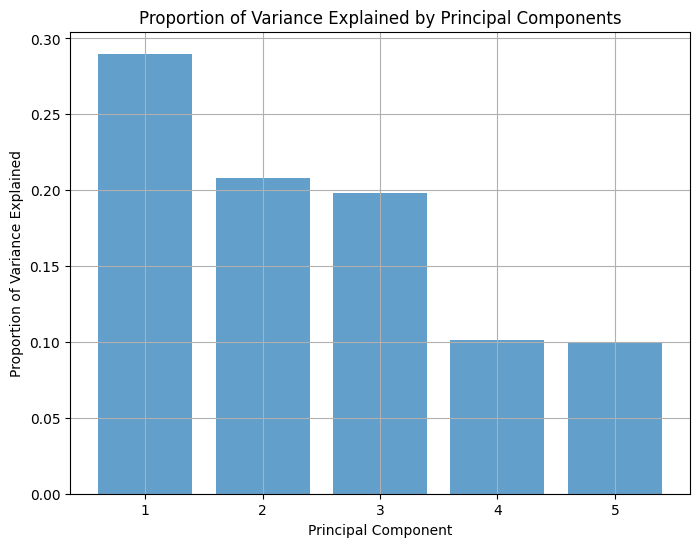

In [ ]:
# Menampilkan proporsi variansi dari 5 komponen utama
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, align='center', alpha=0.7)
plt.xticks(range(1, len(explained_variance) + 1))
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Proportion of Variance Explained by Principal Components')
plt.savefig('variance.png')
plt.grid(True)
plt.show()


# Modelling
Modeling, in the context of data science, refers to the process of developing and applying mathematical or statistical models to analyze data, make predictions, or identify hidden patterns in the data. Steps in modeling include selecting a model that is appropriate for the type of problem and available data, splitting data into training and testing sets, training the model using the training data, validating the model using the testing data, and optimizing the model to improve its performance. The goal of modeling is to produce accurate and reliable models that can be used to make decisions or predictions based on the available data.

In [ ]:
# Pisahkan fitur dan label untuk data train
X_train = pca_df_train.drop(columns='is_fraud')
y_train = pca_df_train['is_fraud']

# Pisahkan fitur dan label untuk data test
X_test = pca_df_test.drop(columns='is_fraud')
y_test = pca_df_test['is_fraud']

# Membuat model Regresi Logistik
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Memprediksi data pengujian
y_pred = log_reg.predict(X_test)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi:", accuracy)


Akurasi: 0.813053613053613


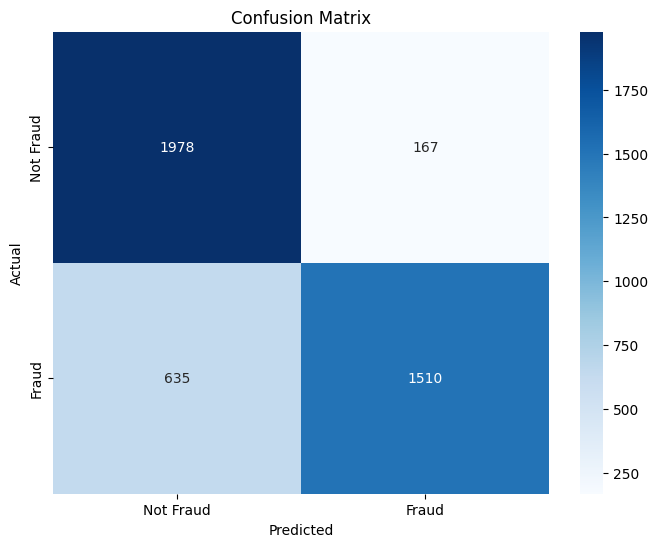

              precision    recall  f1-score   support

   Not Fraud       0.76      0.92      0.83      2145
       Fraud       0.90      0.70      0.79      2145

    accuracy                           0.81      4290
   macro avg       0.83      0.81      0.81      4290
weighted avg       0.83      0.81      0.81      4290



In [ ]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
# Save the image
plt.savefig('matrix_visualization_train.png')
plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

In [ ]:
import joblib
import numpy as np

# 1. Simpan Model
joblib.dump(log_reg, 'logistic_regression_model2.pkl')

['logistic_regression_model2.pkl']

In [ ]:


# 2. Buat Kode untuk Uji Model dengan Data Sintetisl
# Membuat data sintetis
num_samples = 100  # Jumlah sampel data sintetis yang ingin dibuat
num_features = 5  # Jumlah fitur yang sama dengan data asli
synthetic_data = np.random.randn(num_samples, num_features)  # Menggunakan distribusi normal untuk data sintetis

# Memuat model yang telah disimpan
loaded_model = joblib.load('logistic_regression_model2.pkl')

# Memprediksi kelas data sintetis menggunakan model yang dimuat
synthetic_predictions = loaded_model.predict(synthetic_data)

# Menghitung jumlah sampel yang diprediksi sebagai 'fraud' dan 'not fraud'
fraud_count = np.sum(synthetic_predictions == 1)
not_fraud_count = np.sum(synthetic_predictions == 0)

print("Hasil prediksi dari data sintetis:")
print(f"Jumlah 'fraud': {fraud_count}")
print(f"Jumlah 'not fraud': {not_fraud_count}")


Hasil prediksi dari data sintetis:
Jumlah 'fraud': 53
Jumlah 'not fraud': 47


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:

# Membuat DataFrame dari data sintetis
synthetic_df = pd.DataFrame(data=synthetic_data, columns=[f'feature_{i+1}' for i in range(num_features)])

# Menambahkan kolom 'is_fraud' yang berisi hasil prediksi dari model
synthetic_df['is_fraud'] = synthetic_predictions

# Menampilkan lima baris pertama dari DataFrame data sintetis
print("Dataframe dari data sintetis:")
print(synthetic_df)


Dataframe dari data sintetis:
    feature_1  feature_2  feature_3  feature_4  feature_5  is_fraud
0    1.579900   1.092286   1.594803   1.867845  -0.979161         1
1   -0.540223  -1.416059   0.121753   0.113254  -0.946333         0
2    0.106774  -0.434792   0.758578  -0.178019  -0.627953         0
3    1.766860   1.601668   1.690460   0.548087  -0.555137         1
4    1.854428  -1.455087   0.477499  -0.634380   1.187431         1
..        ...        ...        ...        ...        ...       ...
95   0.981337  -2.106688  -0.092755   0.024692  -0.068230         1
96  -0.585943   0.989047  -0.222689   0.856613  -0.168884         1
97  -0.410171  -0.143441   0.598057   0.533741  -1.509141         0
98   1.168924   0.906633   0.435193   0.807698   0.816611         1
99   0.914841   0.335440  -0.016100  -0.869814   0.645094         0

[100 rows x 6 columns]


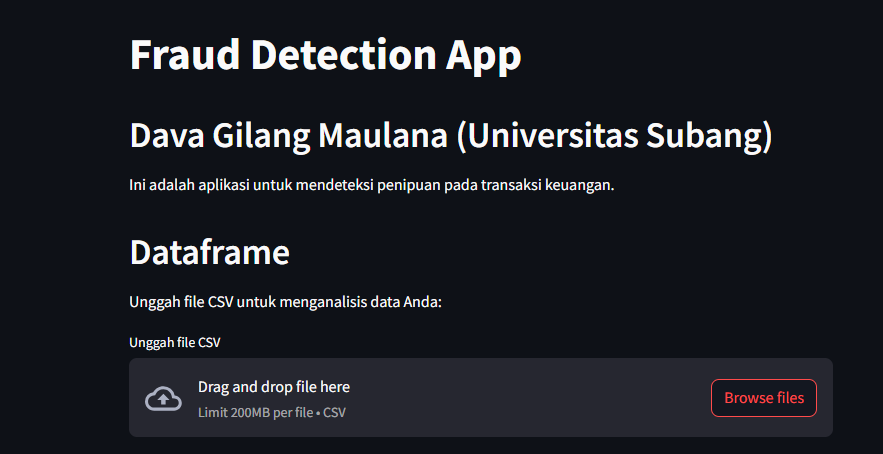

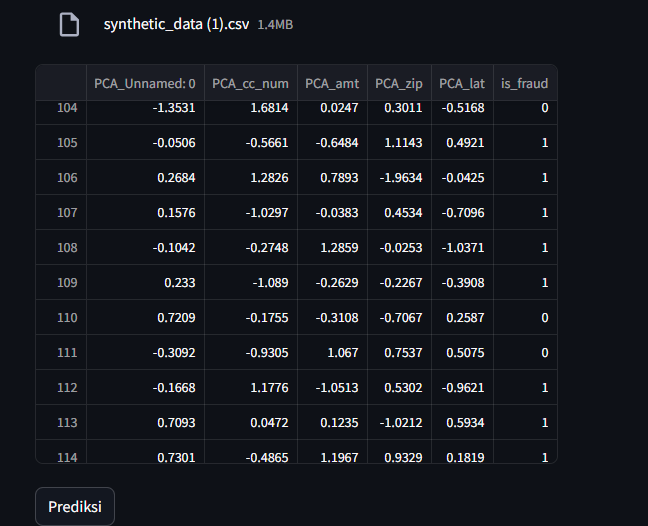